In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [16]:
# fix random seed for reproducibility
tf.random.set_seed(7)

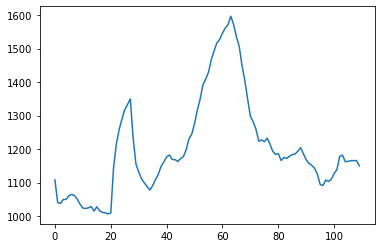

In [17]:
# Use a random dataset for testing
import pandas as pd
import matplotlib.pyplot as plt
dataframe = pd.read_csv('timeseries1.csv', usecols=[2], engine='python')
dataframe = dataframe.rolling(min_periods=1, window=7).mean().values
dataframe = pd.DataFrame(dataframe)
plt.plot(dataframe)
plt.show()

In [18]:
# Change the dataset format to float
dataset = dataframe.values
dataset = dataset.astype('float32')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [19]:
# split into train and test sets
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

82 28


In [20]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [21]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# print(trainX)

# for i in range(trainX.shape[0]):
#     print(i, trainX[i, 0], trainY[i])

In [22]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [23]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
80/80 - 2s - loss: 0.1973 - 2s/epoch - 28ms/step
Epoch 2/100
80/80 - 0s - loss: 0.1505 - 144ms/epoch - 2ms/step
Epoch 3/100
80/80 - 0s - loss: 0.1132 - 103ms/epoch - 1ms/step
Epoch 4/100
80/80 - 0s - loss: 0.0862 - 99ms/epoch - 1ms/step
Epoch 5/100
80/80 - 0s - loss: 0.0700 - 100ms/epoch - 1ms/step
Epoch 6/100
80/80 - 0s - loss: 0.0607 - 105ms/epoch - 1ms/step
Epoch 7/100
80/80 - 0s - loss: 0.0556 - 100ms/epoch - 1ms/step
Epoch 8/100
80/80 - 0s - loss: 0.0516 - 99ms/epoch - 1ms/step
Epoch 9/100
80/80 - 0s - loss: 0.0479 - 98ms/epoch - 1ms/step
Epoch 10/100
80/80 - 0s - loss: 0.0437 - 97ms/epoch - 1ms/step
Epoch 11/100
80/80 - 0s - loss: 0.0398 - 100ms/epoch - 1ms/step
Epoch 12/100
80/80 - 0s - loss: 0.0360 - 99ms/epoch - 1ms/step
Epoch 13/100
80/80 - 0s - loss: 0.0318 - 94ms/epoch - 1ms/step
Epoch 14/100
80/80 - 0s - loss: 0.0279 - 95ms/epoch - 1ms/step
Epoch 15/100
80/80 - 0s - loss: 0.0242 - 95ms/epoch - 1ms/step
Epoch 16/100
80/80 - 0s - loss: 0.0203 - 97ms/epoch - 1ms/s

In [24]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 25ms/step
Train Score: 32.84 RMSE
Test Score: 14.77 RMSE


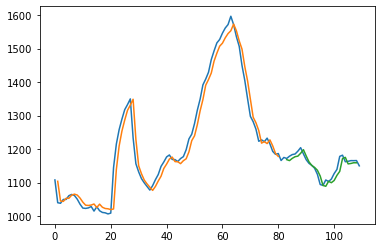

In [25]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [26]:
data = pd.read_csv('monkeypox_daily.csv')
data = data[data['location'] == 'United States']
data = data[data['date']<='2022-09-20']
y=data['new_cases_smoothed'].to_numpy()
# X=dataframe[0].rolling(window=7,min_periods=1).mean().values
X=dataframe[0].to_numpy()

x_train, x_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

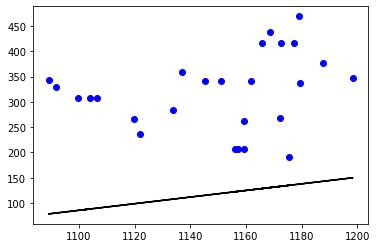

In [29]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train,y_train)
testPredict=testPredict.reshape(-1, 1)
y_pred=reg.predict(testPredict)
plt.scatter(testPredict, y_test[(look_back+1):], color ='b')
plt.plot(testPredict, y_pred, color ='k')
plt.show()

In [30]:
from sklearn.metrics import r2_score
r2_score(y_test[(look_back+1):],y_pred)

-7.3399774877052515

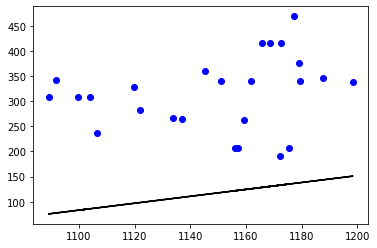

1
-7.575613410782667


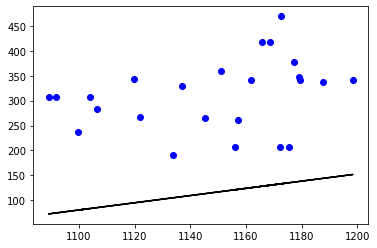

2
-7.6418099577200564


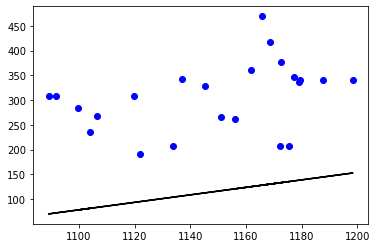

3
-7.774487884595484


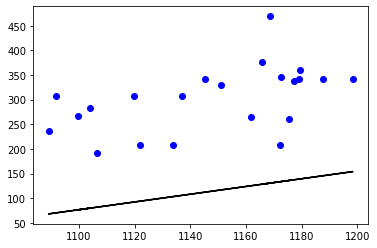

4
-7.941751431609534


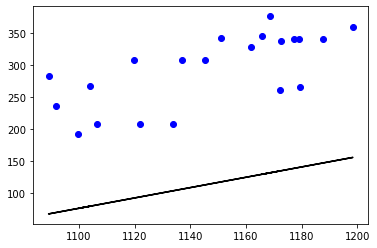

5
-10.028964441390622


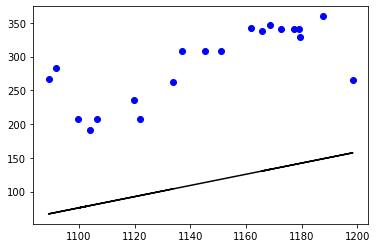

6
-10.214687568489776


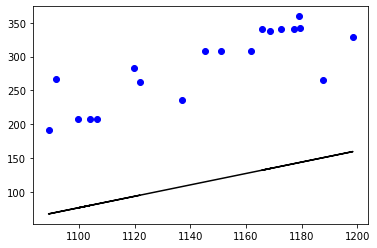

7
-9.663592476244453


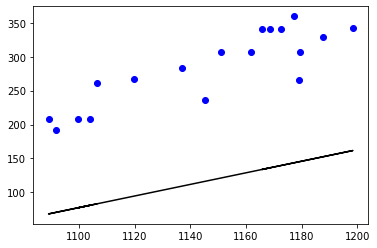

8
-8.93533332277616


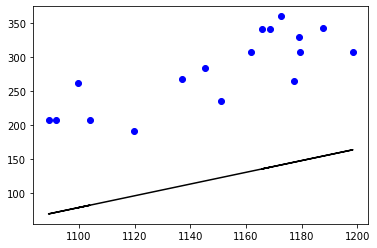

9
-8.26453571234886


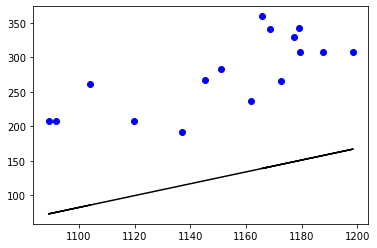

10
-7.512033952206709


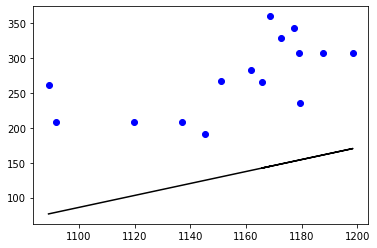

11
-6.83044319779318


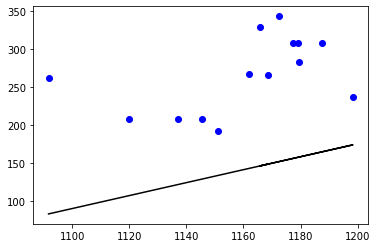

12
-6.58563382641781


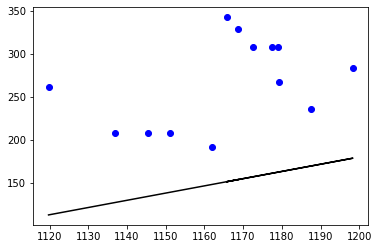

13
-5.252826526518683


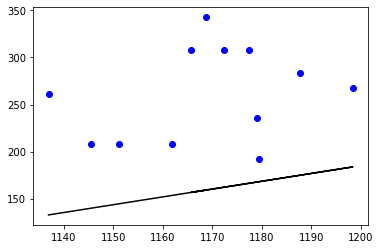

14
-4.402869839381043


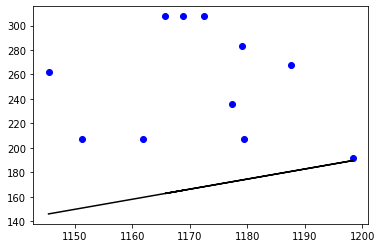

15
-4.119594047530379


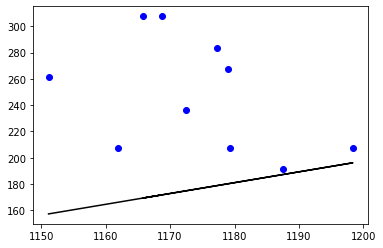

16
-3.2766525101758566


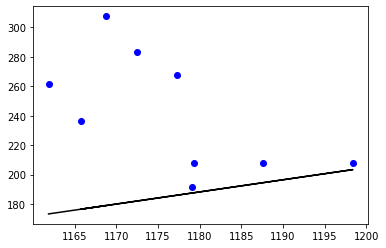

17
-2.4550931717187603


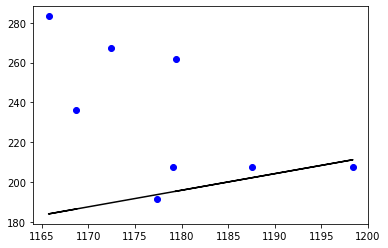

18
-1.802100841841757


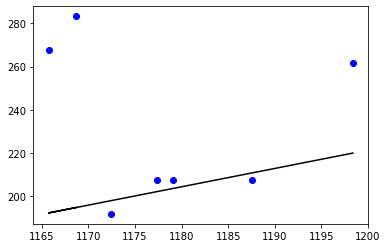

19
-0.8771135699665131


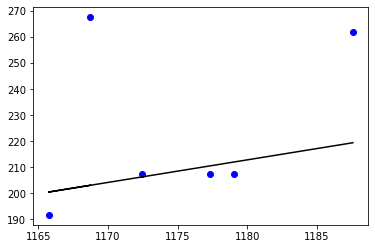

20
-0.1711326717394328


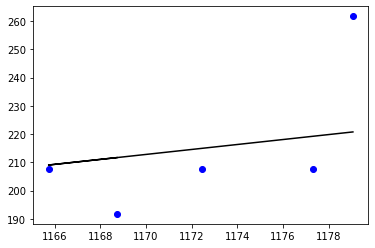

21
0.21501211533278086


In [31]:
for i in range(1,22):
    trainX=x_train[:(len(x_train)-i)]
    trainY=y_train[i:]
    reg = LinearRegression().fit(trainX,trainY)
    testPredict=testPredict.reshape(-1, 1)
    y_pred=reg.predict(testPredict[:(len(testPredict)-i)])
    plt.scatter(testPredict[:(len(testPredict)-i)], y_test[(look_back+1+i):], color ='b')
    plt.plot(testPredict[:(len(testPredict)-i)], y_pred, color ='k')
    plt.show()
    print(i)
    print(r2_score(y_test[(look_back+1+i):],y_pred))